In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gs
donors = [f'TBd{k}' for k in range(1,7)]
TARGET_LOCUS='IGH'
from scipy.stats import binom

######################## PATH CONFIG ################################

full_df_loc = '../../data/vdj/integrated_cell_calls_ambient_annotated.tsv.gz'
ASC_subtype_df_loc = '../../data/annotation/subtypes/ASC_subtypes.tab'
sample_relationships_df_loc = '../../snakemake_workflow/samplesheets/sample_relationships.tsv'
FIGURE_OUTDIR = '../figures/paper figures/EDFigure4'
######################## ############ ################################
from tb_colormaps import *
plt.style.use('../scripts/bursa.mplstyle')

pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 20)
pd.set_option("display.width", 100)
%load_ext autoreload
%autoreload 2


# Read data

In [2]:
df = pd.read_table(full_df_loc, low_memory=False, usecols = ['sample_uid_vdj',
                                                             'sample_uid',
                                                             'sample_uid_gex',
                                                             'cb',
                                                             'c_call',
                                                             'vdj_sequence',
                                                             'v_identity',
                                                             'v_mismatch',
                                                             'n_umis',
                                                             'lineage_id',
                                                             'donor', 
                                                             'tissue',
                                                             'cycling',
                                                             'correlation_cycling',
                                                             'multiplet_status',
                                                             'probable_hq_single_b_cell',
                                                             'is_ambient_source',
                                                             'vdj_is_from_ambient',
                                                             'Immune_All_Low_predicted_labels'])
df = df[(df.vdj_sequence.notna()) & (df.lineage_id.notna())]
df['donor_tissue'] = df['donor'] + "_" + df['tissue']

celltypist_simpler = {
    "Proliferative germinal center B cells": "GC B cells",
    "Germinal center B cells": "GC B cells", 
    "Age-associated B cells" : "ABCs"
}

ASC_subtype_df = pd.read_table(ASC_subtype_df_loc)

#ASC_subtype_df['cb'] = ASC_subtype_df.barcode.str.split("-").map(lambda x: x[0])
#ASC_subtype_df['cb_suid'] = ASC_subtype_df['cb'] + "_" + ASC_subtype_df['sample_uid_gex']
ASC_subtype_dict = ASC_subtype_df.set_index('cb_suid')['subtype'].to_dict()
df['cb_suid'] = df['cb'] + "_" + df['sample_uid_gex']
df['ASC_subtype'] = df.cb_suid.map(ASC_subtype_dict)
df['celltype'] = df['Immune_All_Low_predicted_labels'].copy()
df['celltype'] = df.celltype.map(lambda x: celltypist_simpler.get(x,x))
df.loc[df.ASC_subtype.notna(), 'celltype'] = df['ASC_subtype']


df_clean = df[(df.probable_hq_single_b_cell==True) & (df.multiplet_status==1) & ~(df.vdj_is_from_ambient == True).astype(bool)].copy()
naive =df_clean.Immune_All_Low_predicted_labels == 'Naive B cells'
unswitched = df_clean.c_call.isin(['IGHM','IGHD'])
permitted = (naive & unswitched) | ~(naive.astype(bool))
df_clean = df_clean[permitted]
df_clean = df_clean[~df_clean.celltype.str.startswith('Plasma')]


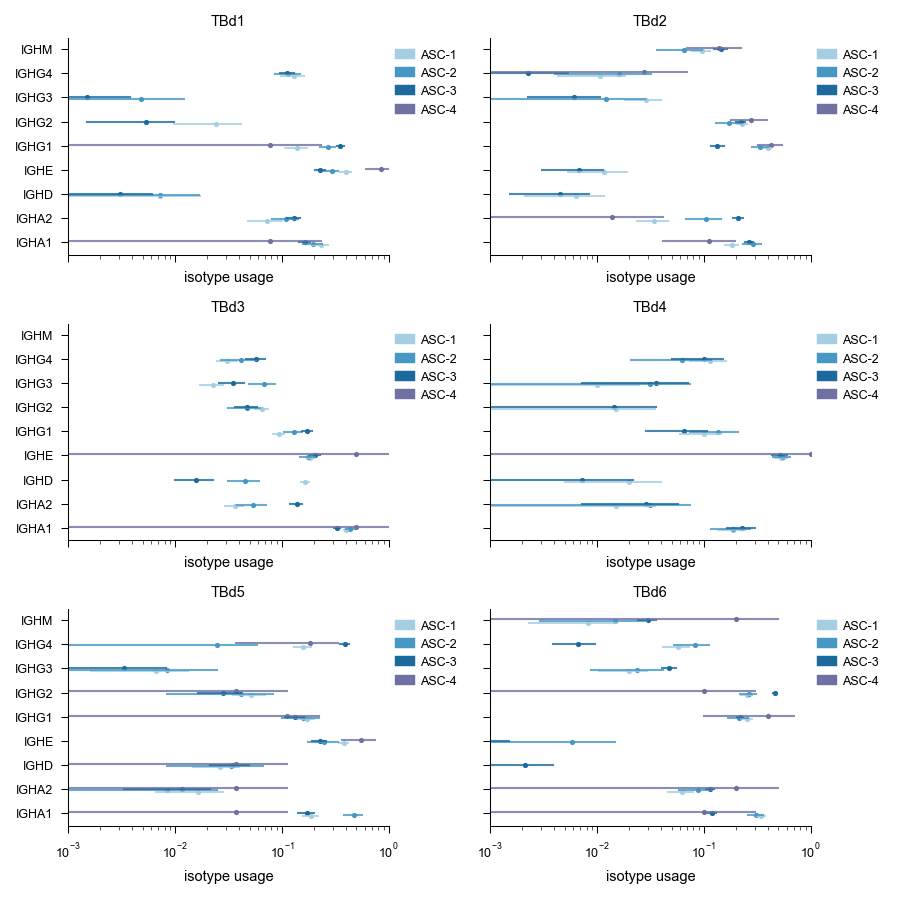

In [3]:
fig, axes = plt.subplots(3,2, figsize=(6,6), sharex=True, sharey=True)
axes = axes.flatten()

for it, donor in enumerate([f'TBd{i}' for i in range(1,7)]):
    ax = axes[it]
    ax.set_title(donor)
    isotype_usage = df_clean[df_clean.ASC_subtype.notna() & (df_clean.donor==donor)].groupby(['celltype','c_call']).size().reset_index()
    isotype_usage = isotype_usage.rename(columns = {0:'n'})
    totals = isotype_usage.groupby('celltype')['n'].sum()
    isotype_usage['total'] = isotype_usage.celltype.map(totals)
    isotype_usage['fraction'] = isotype_usage['n'] / isotype_usage['total']
    CI = binom.interval(0.95, n= isotype_usage.total, p = isotype_usage.fraction)
    isotype_usage['95_CI_lower'] = CI[0]/isotype_usage['total']
    isotype_usage['95_CI_upper'] = CI[1]/isotype_usage['total']
    isotype_usage['fraction'] = isotype_usage['fraction']# + np.maximum(1/isotype_usage['total'], 10**-4)


    dy = {y:i*0.05-0.1 for i,y in enumerate(sorted(isotype_usage.celltype.unique()))}
    y_dict = {y:i for i,y in enumerate(sorted(isotype_usage.c_call.unique()))}
    for it, row in isotype_usage.iterrows():
        y =  dy[row.celltype] + y_dict[row.c_call]
        color = bcelltype_colors_alt[row.celltype]
        symbol_kwargs = {'marker':'.'}

        ax.plot([row['95_CI_lower'], row['95_CI_upper']],
                [y,y], 
                color=color,
                lw=1, 
                alpha=0.8)
        ax.scatter(row['fraction'],
                y, 
                color=color, 
                **symbol_kwargs, 
                linewidths=0)
    for label in sorted(isotype_usage.celltype.unique()):
        ax.plot([],[],lw=5, color=bcelltype_colors_alt[label], label=label)
    ax.legend(frameon=False, bbox_to_anchor=(1,1), loc='upper left', handlelength=0.8)
    ax.set_yticks([i for i in range(0,len(y_dict.keys()))], sorted(y_dict.keys()))
    sns.despine(fig)
    ax.set_xscale('log')
    ax.set_xlim([10**-3,1])
    ax.set_xlabel('isotype usage')
fig.tight_layout()

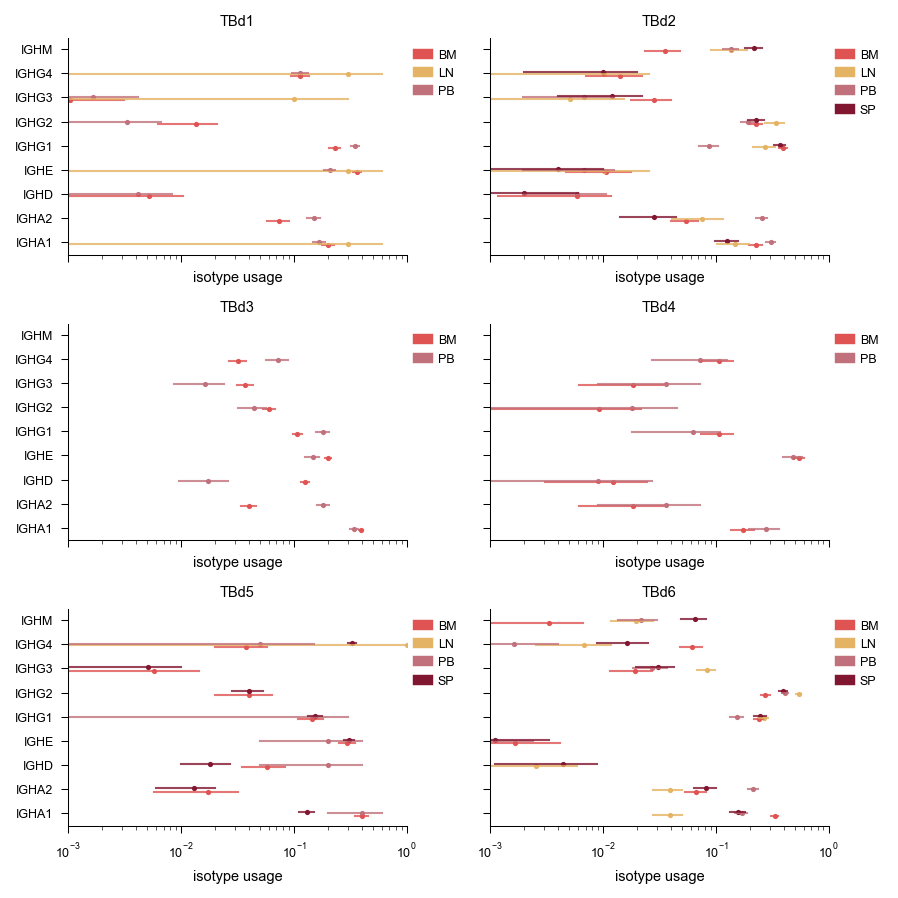

In [4]:
fig, axes = plt.subplots(3,2, figsize=(6,6), sharex=True, sharey=True)
axes = axes.flatten()

for it, donor in enumerate([f'TBd{i}' for i in range(1,7)]):
    ax = axes[it]
    ax.set_title(donor)
    isotype_usage = df_clean[df_clean.ASC_subtype.notna() & (df_clean.donor==donor)].groupby(['tissue','c_call']).size().reset_index()
    isotype_usage = isotype_usage.rename(columns = {0:'n'})
    totals = isotype_usage.groupby('tissue')['n'].sum()
    isotype_usage['total'] = isotype_usage.tissue.map(totals)
    isotype_usage['fraction'] = isotype_usage['n'] / isotype_usage['total']
    CI = binom.interval(0.95, n= isotype_usage.total, p = isotype_usage.fraction)
    isotype_usage['95_CI_lower'] = CI[0]/isotype_usage['total']
    isotype_usage['95_CI_upper'] = CI[1]/isotype_usage['total']
    isotype_usage['fraction'] = isotype_usage['fraction']# + np.maximum(1/isotype_usage['total'], 10**-4)


    dy = {y:i*0.05-0.1 for i,y in enumerate(sorted(isotype_usage.tissue.unique()))}
    y_dict = {y:i for i,y in enumerate(sorted(isotype_usage.c_call.unique()))}
    for it, row in isotype_usage.iterrows():
        y =  dy[row.tissue] + y_dict[row.c_call]
        color = tissue_colors[row.tissue]
        symbol_kwargs = {'marker':'.'}

        ax.plot([row['95_CI_lower'], row['95_CI_upper']],
                [y,y], 
                color=color,
                lw=1, 
                alpha=0.8)
        ax.scatter(row['fraction'],
                y, 
                color=color, 
                **symbol_kwargs, 
                linewidths=0)
    for label in sorted(isotype_usage.tissue.unique()):
        ax.plot([],[],lw=5, color=tissue_colors[label], label=label)
    ax.legend(frameon=False, bbox_to_anchor=(1,1), loc='upper left', handlelength=0.8)
    ax.set_yticks([i for i in range(0,len(y_dict.keys()))], sorted(y_dict.keys()))
    sns.despine(fig)
    ax.set_xscale('log')
    ax.set_xlim([10**-3,1])
    ax.set_xlabel('isotype usage')
fig.tight_layout()

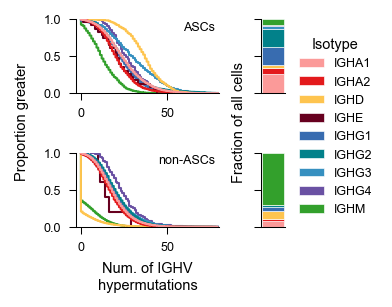

In [5]:
fig= plt.figure(figsize=(1.8,1.8))
gs = fig.add_gridspec(nrows=2, ncols=2, width_ratios=[6,1], wspace=0.5, hspace=0.8)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[1,0], sharex=ax1, sharey=ax1)
ax3 = fig.add_subplot(gs[0,1])
ax4 = fig.add_subplot(gs[1,1], sharex=ax3, sharey=ax3)
axes = [ax1,ax2]
bar_ax = [ax3, ax4]

v_mismatch_df_non_ASC = df_clean[(df_clean.ASC_subtype.isna()) & (df_clean.c_call.str.startswith('IGH'))].groupby(['celltype','c_call', 'vdj_sequence', 'v_mismatch']).size().reset_index()
v_mismatch_df_ASC = df_clean[(df_clean.ASC_subtype.notna()) & (df_clean.c_call.str.startswith('IGH'))].groupby(['celltype','c_call', 'vdj_sequence', 'v_mismatch']).size().reset_index()

g = sns.ecdfplot(v_mismatch_df_non_ASC, x='v_mismatch', hue='c_call', ax=axes[1], palette=IGH_colors, complementary=True, legend=False)    
sns.ecdfplot(v_mismatch_df_ASC, x='v_mismatch', hue='c_call', ax=axes[0], palette=IGH_colors, complementary=True, legend=False)    
# sns.move_legend(g, frameon=False, loc='upper left', bbox_to_anchor=(1,1), title='')
sns.despine(fig)
axes[1].set_xlim([-3,80])
axes[0].set_ylabel('')
axes[1].set_ylabel('')
axes[0].set_xlabel('')
axes[1].text(0.97,0.85,'non-ASCs', transform=axes[1].transAxes, fontsize=6, ha='right')
axes[0].text(0.97,0.85,'ASCs', transform=axes[0].transAxes, fontsize=6, ha='right')
axes[1].set_xlabel('Num. of IGHV\nhypermutations')
fig.supylabel('Proportion greater', fontsize=7, x = -0.1, y=0.5)
# fig.tight_layout()

fractions = pd.crosstab(df_clean[df_clean.c_call.str.startswith('IGH')].ASC_subtype.notna(), df_clean.loc[df_clean.c_call.str.startswith('IGH'), 'c_call'], normalize='index')
fractions = fractions.T
bottoms = fractions.copy()
bottoms.iloc[1:,:] = fractions[:-1].cumsum()
bottoms.iloc[0,:] = 0
bottoms
bar_ax[1].bar(x = 0.5*np.ones(fractions.shape[0]),
              height = fractions[False],
              bottom=bottoms[False],
              color=[get_IGH_colors()[x] for x in fractions.index], lw=0.3, edgecolor='w', 
              label=fractions.index)
bar_ax[0].bar(x = 0.5*np.ones(fractions.shape[0]),
              height = fractions[True],
              bottom=bottoms[True],
              color=[get_IGH_colors()[x] for x in fractions.index], lw=0.3, edgecolor='w', 
              label=fractions.index)
bar_ax[0].legend(frameon=False, loc='upper left', bbox_to_anchor=(1.1,0.9), title='Isotype')
bar_ax[0].set_xticks([])
bar_ax[1].set_xticks([])
bar_ax[0].set_yticklabels([])
bar_ax[1].set_yticklabels([])
bar_ax[0].set_ylim([0,1])
fig.text(0.73,0.5, 'Fraction of all cells', rotation=90, fontsize=7, va='center', ha='center')
fig.savefig(f'{FIGURE_OUTDIR}/isotype_usage.pdf', bbox_inches='tight')